# AAIT homework 2

## Imports

In [26]:
import urllib
import shutil
import os

import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import transforms, datasets 
import torchvision

## Exploring the data 

In [4]:
# Preprocessing the data
# resizing the images, converting to a uniform format
dir_data = './data/task1/train_data/'
# Read the annotations file into a DataFrame
df = pd.read_csv(f'{dir_data}annotations.csv')

# Print the DataFrame
print(df)

                                           sample  label
0          task1/train_data/images/labeled/0.jpeg      0
1          task1/train_data/images/labeled/1.jpeg      1
2          task1/train_data/images/labeled/2.jpeg      2
3          task1/train_data/images/labeled/3.jpeg      3
4          task1/train_data/images/labeled/4.jpeg      4
...                                           ...    ...
23550  task1/train_data/images/labeled/23550.jpeg     97
23551  task1/train_data/images/labeled/23551.jpeg     28
23552  task1/train_data/images/labeled/23552.jpeg     53
23553  task1/train_data/images/labeled/23553.jpeg      9
23554  task1/train_data/images/labeled/23554.jpeg     90

[23555 rows x 2 columns]


In [43]:
# Get the unique values in the 'label' column
unique_labels = df['label'].unique()

# Print the unique values
print(unique_labels)

# Get the number of unique values in the 'label' column
num_unique_labels = df['label'].nunique()

# Print the number of unique values
print(f"There are {num_unique_labels} classes")

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
There are 100 classes


<AxesSubplot: >

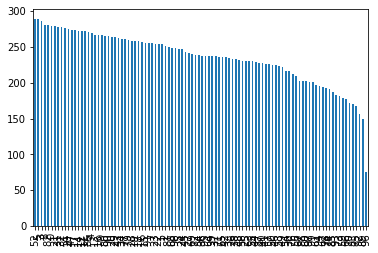

In [39]:

# Get the count of each class label
label_counts = df['label'].value_counts()
# Plot the label counts as a bar chart
label_counts.plot.bar()

## Training on the labeled data 
In order to prove that the semi-supervised learning task is superior to the supervised learning task. We should train the model first only on the samples that are labeled. Later if we see an improvement in the training where we take into account also the unlabeled data, compared to this example, we have proved the point.

Reference: 
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://pytorch.org/hub/pytorch_vision_mobilenet_v2/

In [ ]:
# Prepare dataset for training
# The image should be 3 channel RGB, HW should be at least 224
# Images should be in range [0,1] and then normalized using 
# mean = [0.485, 0.456, 0.406] and 
# std = [0.229, 0.224, 0.225]


### Run the model

In [12]:
%%capture
# Download a pytorch MobileNet pretrained model
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval()

In [15]:
# change the Linear output
# print(model.classifier)
# > Sequential(
#   (0): Dropout(p=0.2)
#   (1): Linear(in_features=1280, out_features=1000, bias=True)
# )
model.classifier[1] = nn.Linear(1280, 100)
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=100, bias=True)
)


In [16]:
# sample execution (requires torchvision)
img_path = df.iloc[1]["sample"]
input_image = Image.open(f"data/{img_path}")
preprocess = transforms.Compose([
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# sanity check
print(input_batch.shape)

torch.Size([1, 3, 64, 64])


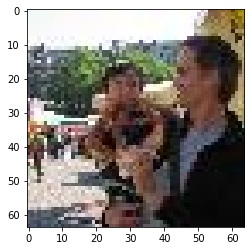

In [17]:
plt.imshow(input_image)

In [18]:
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 100
print(output[0].shape)
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0) 
# select the maximum value to find the class predicted
print(f"predicted class: {torch.argmax(probabilities).item()}")
true_label = df.iloc[1]["label"]
print(f"true label: {true_label}")

torch.Size([100])
predicted class: 90
true label: 1


### Organize data for pytorch ImageFolder 

In [70]:
# Define the base directory
base_dir = 'data/task1/labeled'

# Loop through the classes
for i in range(100):
    # Create the directory for the class
    class_dir = f'{base_dir}/class{i}'
    os.makedirs(class_dir)

In [7]:
# Define the base directory
base_dir = 'data/task1/labeled'

# Iterate over the rows in the DataFrame
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    # Extract the path and class from the row
    path = row['sample']
    label = row['label']
    
    # Create the directory for the class
    class_dir = f'{base_dir}/class{label}'
    os.makedirs(class_dir, exist_ok=True)
    
    # Copy the file to the class directory
    shutil.copy(f"data/{path}", class_dir) 

100%|██████████| 23555/23555 [54:40<00:00,  7.18it/s]   


In [23]:
data_dir = 'data/task1/labeled'
image_dataset = datasets.ImageFolder(data_dir, preprocess)
# print(image_datasets)

In [24]:
dataloaders  = torch.utils.data.DataLoader(image_dataset, batch_size = 4, shuffle = True, num_workers = 4)

In [25]:
dataset_sizes = len(image_dataset)
class_names = image_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Visualize few images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Familiarizing with specific challenges 
### missing labels 
- The classification problem can be tackled using semi-supervised learning methods. There are 3 propular approaches to address semi-supervised learning problems:
  - self training
  - co-training
  - graph-based models
- self training 
  - What is the process?
    - First train on labeled data
    - Make predictions on the untrained data
    - From those predictions, only extract those with high confidence and move them to the training data
    - Repeat the process until convergence or no high-confidence exmples left in the unlabeled set.
  - Disadvantage is that you can still generate incorrect predictions and the mistakes can be amplified in the subsequent trainings of the model.
- co-training
  - requires two feature representations associated with the dataset which serve as two different views of the data
  - The representations are dissimilar and conditionally independet, but they can provide complementary information about the data. 
  - We cannot do this for image classification because we have only visual representations of the data.
- graph-based models
  - labeled and unlabeled samples are represented as different nodes in a graph
  - the edges in this graph denote the similarity between nodes.
  - The assumption in this approach is that nodes with strong edges are likely to share the same label.
  - The algorithm to compute the labels is:
    - The unlabeled nodes can be labeled using random-walk over the graph. Based on the strength of the edges.
    - The walk ends when a labeled node is reached 
    - A probability that the random walker started at a particular unlabeled node given that it ended at a specific labeled node is computed. i.e. 2 poitns are similar if they have indistinguishabel starting points.


Reference: 
- https://www.kdnuggets.com/2019/11/tips-class-imbalance-missing-labels.html

### noisy labels


In [ ]:
# k-fold cross-validation, 
# ensemble methods, 
# or importance sampling

### Preprocessing the data according to challange of missing labels

# Solving the task 1

In [ ]:
# Fine tune the classifier
# try different parameters for the training: lr, regularization

# Test the model